In [ ]:
import os
import re
import sys
import pdb

import numpy as np
import matplotlib as mp
import pandas as pd
import scipy as sp
import scipy.stats as spt
import scipy.io as sio
import matplotlib.pyplot as plt

from tasks import dual2afc
from traum import traum as tr
#from traum.mdaio import readmda
#from traum import readDIO
#from traum.readTrodesExtractedDataFile import readTrodesExtractedDataFile as readdat

print(sys.version)

## Behavior

In [2]:
subjName = 'M14'
sessName = 'M14_20171117_175330'
sessNameBpod = 'M14_Dual2AFC_Nov17_2017_Session1.mat'

pathBhv = os.path.join('datasets/dual2afc_ds1/','bhv',subjName,sessNameBpod)
dataBhv = dual2afc.parser(sio.loadmat(pathBhv, squeeze_me=True))

In [3]:
obj = tr.traum(dataBhv)

## Neural

In [4]:
pathNeur = os.path.join('datasets/dual2afc_ds1/','neur',subjName,sessName)

obj.readNeur(pathNeur)

## Sync

In [5]:
pathDIO = os.path.join('datasets/dual2afc_ds1/','neur',subjName,sessName,'dio')
obj.readDio(pathDIO)

obj.sync()

## Traum

In [6]:
obj.neur = obj.neur.append({'cluster': 0, 'dataset': 'water_', 'spikes': obj.dio['time'][(obj.dio['state']==20) | (obj.dio['state']==21)].values},ignore_index=True)


reload(tr)
self = obj

In [14]:
def raspeth(self,alignment,iUnit,trialMask,panes,window=(-1,2),bins='rice',conv='None'):
    ha_raster, ha_peth = panes
    ndxType, colors = trialMask # ndxType {0, 1, 2, ...} is trial type, trials discarded where 0 // len(colors) = len(set(ndx[ndx>0]))
    setType = list(set(ndxType[ndxType>0]))
    offset = 0
    listAlign = np.array(self.dio['time'][self.dio['state']==0]) + np.array(self.bhv.parsedData[alignment])
    if type(bins)!=str:
        bins = np.linspace(window[0],window[1],bins)
    for iType in setType:
        ndx = (ndxType == iType) & (np.logical_not(np.isnan(listAlign)))
        if any(ndx):
            spikes = [[]]*sum(ndx)
            i = 0
            for iTrial in np.nonzero(ndx)[0]:
                temp = self.neur['spikes'][iUnit] - listAlign[iTrial]
                spikes[i] = temp[(temp>=window[0]) & (temp<=window[1])]
                i += 1

            ha_raster.eventplot([[]]*offset + spikes,colors=colors[iType-1])
            ha_raster.set_xlim(window)
            offset += sum(ndx)

            counts, edges = np.histogram([item for sublist in spikes for item in sublist], bins=bins, density=False)
            #pdb.set_trace()
            if (type(conv)!=str) :# or (conv != 'None') or (conv != 'none'):
                counts = np.convolve(counts,conv,mode='same')
            ha_peth.plot(edges[:-1]+(edges[1]-edges[0])/2,counts/(edges[1]-edges[0])/sum(ndx),color=colors[iType-1])

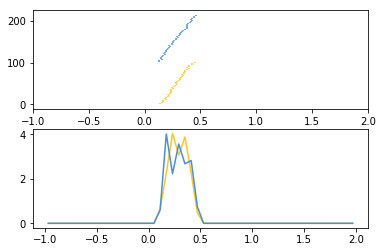

In [15]:
listAlign = ('tsCin','tsStimOn','tsStimOff','tsChoice','tsRwd','tsErrTone')
alignment = listAlign[4]
window=[-1,2]
iUnit = 32
fig, panes = plt.subplots(2,1)

cho_ndxType = np.full(len(obj.bhv.parsedData),0)
cho_ndxType[obj.bhv.parsedData['isChoiceLeft']] = 1
cho_ndxType[obj.bhv.parsedData['isChoiceRight']] = 2
cho_colors =['xkcd:golden yellow', 'xkcd:dark sky blue']
cho_trialMask = (cho_ndxType, cho_colors)

raspeth(obj,alignment,iUnit,cho_trialMask,panes,bins=51)
#aligner = np.array(self.dio['time'][self.dio['state']==0]) + np.array(self.bhv.parsedData[alignment])

In [ ]:
tsDio = obj.dio[obj.dio['state']==0]['time']
tsBhv = obj.bhv.parsedData['tsState0']
plt.scatter(np.diff(tsDio),np.diff(tsBhv))
lim = (0,300)
plt.xlim(lim)
plt.ylim(lim)

In [ ]:
syncs = pd.DataFrame({'tsDio': tsDio.values, 'tsBhv': tsBhv.values})
syncs['Dio-Bhv']= syncs['tsDio']-syncs['tsBhv']
syncs

In [ ]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
dat = sm.datasets.get_rdataset("Guerry", "HistData").data
results = smf.ols('Lottery ~ Literacy + np.log(Pop1831)', data=dat).fit()
print(results.summary())

In [ ]:
type(dat)